<a href="https://colab.research.google.com/github/gaixen/BCS_recruitment/blob/main/The%20Goblet%20of%20Fire/demo_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
pip install constants

In [31]:
pip install pygame gymnasium

# Loading dependencies

In [32]:
from collections import defaultdict
import gymnasium as gym
import numpy as np
import pygame
import random
from constants import *
from collections import deque
# from maze_loader import load_maze

In [33]:
#seting up the visuals for the maze 10 by 15
cell_size=40 #pixels
maze_width=15
maze_height=10
screen_width=maze_width*cell_size
screen_height=maze_height*cell_size
white=(255,255,255)
black=(0,0,0)
red=(255,0,0)
green=(0,255,0)
blue=(0,0,255)
gray=(160,160,160)

In [34]:
wall_file='/content/V1.txt'
def maze(wall_file):
  walls=set()
  cup=None
  with open(wall_file,'r')as f:
    for y,line in enumerate(f):
      for x,char in enumerate(line.strip()):
        if char=='x':
          walls.add((x,y))
        elif char=='*':
          cup=(x,y)

  return walls,cup

# Setting up the enviroment

In [35]:
class createenviroment:
  def __init__(self,wall_file):
      #initialising the enviroment variables walls,cup position etc
      self.walls,self.cup=maze(wall_file)
      self.maze = [[0 for _ in range(maze_width)] for _ in range(maze_height)]
      for (x, y) in self.walls:
        self.maze[y][x] = 1
      self.return_queue=[]
      self.length_queue=[]
      #reset the variables if certain criteria don't match
      #reset conditions defined later
      self.reset()

  def get_randomposition(self):
    #generating random positions not coinsiding with the walls
    while True:
      x=random.randint(0,maze_width-1)
      y=random.randint(0,maze_height-1)
      if (x,y) not in self.walls:
        return (x,y)
      else:
        pass

  def reset(self):
    #reseting preacher position in case it coinsides randomly with harry's position
    self.harry=self.get_randomposition()
    self.preacher=self.get_randomposition()
    self.cup=self.get_randomposition()
    if self.preacher==self.harry:
      self.preacher=self.get_randomposition()
    elif self.preacher==self.cup:
      self.cup=self.get_randomposition()
    elif self.harry==self.cup:
      self.cup=self.get_randomposition()
    self.done=False
    observation = (self.harry[0], self.harry[1],
                   self.preacher[0] - self.harry[0], self.preacher[1] - self.harry[1],
                   self.cup[0] - self.harry[0], self.cup[1] - self.harry[1])
    return observation

  def valid_move(self,position):
    return (0<=position[0]<maze_width) and (0<=position[1]<maze_height) and (position not in self.walls)

  def step(self,action):
    #classifying all moves in 4 categories
    x,y=self.harry
    if action==0:#left
      update_position=(x-1,y)
    elif action==1:#right
      update_position=(x+1,y)
    elif action==2:#up
      update_position=(x,y-1)
    elif action==3:#down
      update_position=(x,y+1)
    else:
      update_position=(x,y)

    if self.valid_move(update_position):
      self.harry=update_position
    else:
      self.harry=self.harry

    self.move_preacher()
    reward=self.get_reward()
    self.done=self.harry==self.cup or self.harry==self.preacher
    observation = (self.harry[0], self.harry[1],
                   self.preacher[0] - self.harry[0], self.preacher[1] - self.harry[1],
                   self.cup[0] - self.harry[0], self.cup[1] - self.harry[1])

    terminated =(self.harry==self.cup)
    truncated =(self.harry==self.preacher)
    self.done = terminated or truncated
    info = {
        "harry_position": self.harry,
        "preacher_position": self.preacher,
        "cup_position": self.cup
    }
    return observation, reward, terminated, truncated, info

  def get_reward(self):
    if self.harry==self.cup:
      return 100
    elif self.harry==self.preacher:
      return -100
    elif self.harry==self.walls:
      return -5
    else:
      return -1
#implementation of Breadth first search algorithm

  def move_preacher(self):
    next_step=self.bfs(self.preacher,self.harry)
    if next_step:
      self.preacher=next_step

  def bfs(self,start,goal):#breadth first search algorithm
    # start=self.harry
    # goal=self.cup
    # if start==goal:
    #   return start

    queue=deque()
    queue.append((start,[]))
    visited=set()
    visited.add(start)

    while queue:

      current_position,path=queue.popleft()
      x,y=current_position
      movement=[(1,0),(-1,0),(0,1),(0,-1)]
      for h,k in movement:
        update_position=(x+h,y+k)

      if not self.valid_move(update_position)or update_position in visited:
        continue

      if update_position==goal:
        return path[0] if path else update_position

      queue.append((update_position,path+[update_position]))
      visited.add(update_position)

    return start

In [36]:
env=createenviroment('/content/V1.txt')

## **Visualization using pygame**
# Disclaimer:Run at your own risk

---



In [37]:
# pygame.init()
# screen=pygame.display.set_mode((screen_width,screen_height))
# pygame.display.set_caption("enviroment visualisation using pygame")
# env=createenviroment('/content/V1.txt')
# running=True
# while running:
#   screen.fill(white)

#   for event in pygame.event.get():
#     if event.type==pygame.QUIT:
#       running=False

#   for (x,y) in env.walls:
#     pygame.draw.rect(screen,gray,(x*cell_size,y*cell_size,cell_size,cell_size))

# harry_x, harry_y = env.self.harry
# pygame.draw.rect(screen, blue, (harry_x * cell_size, harry_y * cell_size, cell_size, cell_size))
# preacher_x, preacher_y = env.self.preacher
# pygame.draw.rect(screen, red, (preacher_x * cell_size, preacher_y * cell_size, cell_size, cell_size))
# cup_x, cup_y = env.self.cup
# pygame.draw.rect(screen, green, (cup_x * cell_size, cup_y * cell_size, cell_size, cell_size))
# pygame.display.flip()

# Training the agent

In [49]:
class Qtable:
  def __init__(
      self,
      action,learning_rate=0.01,
      discount_factor=0.95,
      epsilon=1,
      epsilon_min=0.01,
      epsilon_decay=0.995,
  ):
      self.q_table=defaultdict(lambda:np.zeros(len(action)))
      self.action=action
      self.lr=learning_rate
      self.gamma=discount_factor
      self.epsilon=epsilon
      self.epsilon_min=epsilon_min
      self.epsilon_decay_rate=epsilon_decay
      self.training_error = deque(maxlen=10000)

  def get_state(self,harry_pos,preacher_pos,cup_pos,maze):
    harry_x,harry_y=harry_pos
    preacher_x,preacher_y=preacher_pos
    cup_x,cup_y=cup_pos
    def is_wall(x, y):
        if 0 <= x < len(maze) and 0 <= y < len(maze[0]):
            return 1 if maze[x][y] == 1 else 0  # 1 = wall
        return 1
    wall_up=is_wall(harry_x,harry_y-1)
    wall_down=is_wall(harry_x,harry_y+1)
    wall_left=is_wall(harry_x-1,harry_y)
    wall_right=is_wall(harry_x+1,harry_y)
    return (harry_x,harry_y,preacher_x-harry_x,preacher_y-harry_y,cup_x-harry_x,cup_y-harry_y,wall_up,wall_down,wall_left,wall_right)

  def chooseaction(self,state):#choose between expoartion and expoitation
    if random.random() < self.epsilon:#exploration
      return random.choice(self.action)
    else:#exploitation
      state_key = state
      return np.argmax(self.q_table[state])

  def update(self, state, action, reward, next_state):
    state_key = state
    next_state_key = next_state
    best_next_action = np.max(self.q_table[next_state_key])
    temporal_difference_target = reward + self.gamma * best_next_action
    temporal_difference_error = temporal_difference_target - self.q_table[state_key][action]
    self.q_table[state_key][action] += self.lr * temporal_difference_error
    self.training_error.append(temporal_difference_error)

  def decay_epsilon(self):
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay_rate



###Balancing epsilon decay over number of episodes

In [50]:
import matplotlib.pyplot as plt
#ensuring epsilon reaches min value after a goog explorative start and not too quick
#ensuring enough exploration before exploitation
#This happens as I kept n_episodes quite large

Text(0, 0.5, 'epsilon')

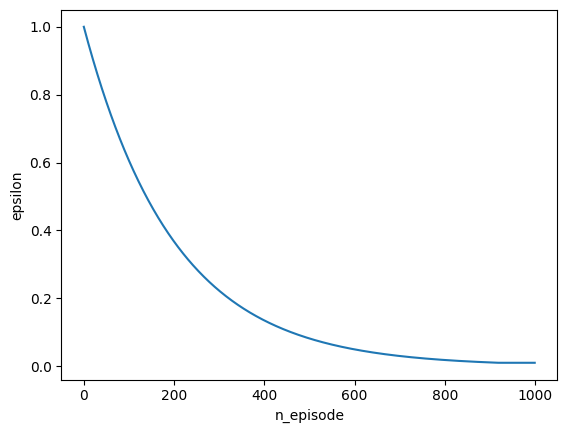

In [51]:
epsilons = []
epsilon = 1.0
for _ in range(1000):
    epsilons.append(epsilon)
    epsilon = max(epsilon * 0.995, 0.01)
plt.plot(epsilons)
plt.xlabel("n_episode")
plt.ylabel("epsilon")

##Training Loop

In [52]:
from tqdm import tqdm
import numpy as np
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
final_epsilon = 0.01

env=createenviroment('/content/V1.txt')
agent = Qtable(action=[0, 1, 2, 3],epsilon_decay=0.995)
num_episode=n_episodes
#a reward list is initialised and a success count is initialised to zero
rewards=[]
success_count=0
env.return_queue = deque(maxlen=n_episodes) # For plotting rewards
env.length_queue = deque(maxlen=n_episodes) # For plotting episode lengths

for episode in tqdm(range(num_episode)):
    #env.reset() returns the initial observation (harry's position)
    initial_harry_pos = env.reset()
    #get the initial state for the Q-learning agent
    harry_pos, cup_pos, preacher_pos = env.harry, env.cup, env.preacher
    state = agent.get_state(harry_pos, preacher_pos, cup_pos,env.maze)

    cumulative_reward = 0
    done = False
    step_count = 0 #track steps per episode


    while not done:
        #action = agent.choose_action(state)
        action = agent.chooseaction(state)
        #env.step returns observation, reward, terminated, truncated, info
        observation, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        #Get the next state from the new positions after the step
        next_harry_pos, cup_pos, preacher_pos = env.harry, env.cup, env.preacher
        next_state = agent.get_state(next_harry_pos, cup_pos, preacher_pos,env.maze)

        #Q-table update
        agent.update(state, action, reward, next_state)

        #transition into the next state
        state = next_state
        cumulative_reward += reward
        step_count += 1

        #the episode ends if terminated or truncated
        done = terminated or truncated

    #decay epsilon after each episode
    agent.decay_epsilon()
    rewards.append(cumulative_reward) #keep track of rewards
    env.return_queue.append(cumulative_reward)
    env.length_queue.append(step_count)

    #success is defined by reaching the cup (reward 100)
    if env.harry == env.cup:
         success_count += 1


    # if episode % 1000 == 0: # Print less frequently for 100k episodes
    #     print(f"\nEpisode {episode}, Reward: {cumulative_reward}, Epsilon: {agent.epsilon:.3f}, Steps: {step_count}")

print(f"Total Success: {success_count} out of {num_episode} episodes")

100%|██████████| 100000/100000 [06:17<00:00, 264.72it/s]

Total Successes: 42564 out of 100000 episodes


# Plotting the observations


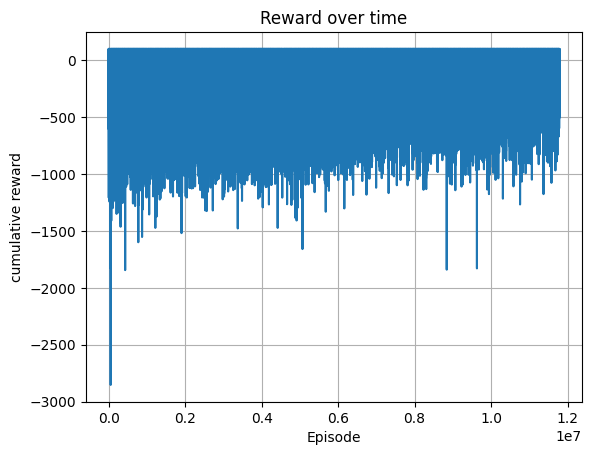

In [53]:
import matplotlib.pyplot as plt
#Plotting Reward against number of episodes
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('cumulative reward')
plt.grid(True)
plt.show()


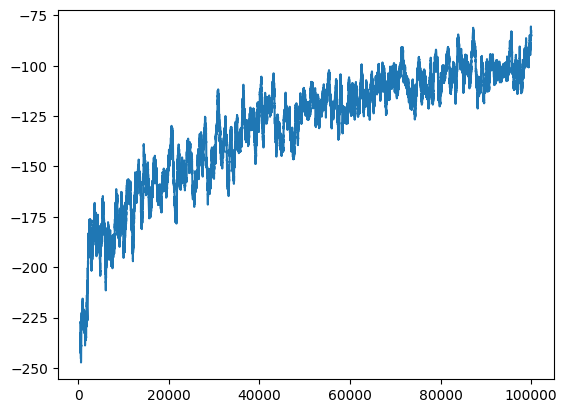

In [54]:
#Plotting a rolling mean for the return value
#since this is subject to take only some values within fixed range
import pandas as pd
smoothed = pd.Series(env.return_queue).rolling(500).mean()
plt.plot(smoothed)